In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Import our debugger
from graph_debugger import GraphDebugger

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline 

### 1. Load Graph Files

Specify the path to your .pt graph files and load them.

In [2]:
debugger = GraphDebugger()

graph_files = [
    "graphs_from_skim/DYTau_M50to120_NanoV15_DYTau_skim_graphs.pt",
]

In [3]:
all_graphs = []
file_info = {}

for file_path in graph_files:
    if os.path.exists(file_path):
        graphs = debugger.load_graphs(file_path)
        all_graphs.extend(graphs)
        file_info[file_path] = {
            'num_graphs': len(graphs),
            'start_idx': len(all_graphs) - len(graphs),
            'end_idx': len(all_graphs)
        }
        print(f"Loaded {len(graphs)} graphs from {file_path}")
    else:
        print(f"File not found: {file_path}")

print(f"\nTotal graphs loaded: {len(all_graphs)}")
if all_graphs:
    print(f"Sample graph shape: {all_graphs[0].x.shape}")
    print(f"Sample graph edges: {all_graphs[0].edge_index.shape}")

Loaded 605 graphs from graphs_from_skim/DYTau_M50to120_NanoV15_DYTau_skim_graphs.pt
Loaded 605 graphs from graphs_from_skim/DYTau_M50to120_NanoV15_DYTau_skim_graphs.pt

Total graphs loaded: 605
Sample graph shape: torch.Size([19, 9])
Sample graph edges: torch.Size([2, 342])


### 2. Dataset Overview

Get basic statistics and visualizations of the entire dataset.

In [4]:
if all_graphs:
    
    stats = debugger.get_basic_stats(all_graphs)
    
    print("=== Dataset Statistics ===")
    print(f"Total graphs: {stats['total_graphs']}")
    print(f"Nodes per graph: {stats['min_nodes']} - {stats['max_nodes']} (avg: {stats['avg_nodes']:.1f}, median: {stats['median_nodes']:.1f})")
    print(f"Edges per graph: {stats['min_edges']} - {stats['max_edges']} (avg: {stats['avg_edges']:.1f})")
    print(f"BSM tau graphs: {stats['bsm_tau_counts']} ({stats['bsm_tau_counts']/stats['total_graphs']*100:.1f}%)")
    
    if stats['dr_values']:
        print(f"DeltaR tau-fatjet: {stats['min_dr']:.3f} - {stats['max_dr']:.3f} (avg: {stats['avg_dr']:.3f})")
    
    issues = debugger.check_graph_sanity(all_graphs)
    total_issues = sum(len(issue_list) for issue_list in issues.values())
    
    print(f"\n=== Sanity Check ===")
    if total_issues == 0:
        print("No issues found!")
    else:
        print(f"Found {total_issues} potential issues:")
        for issue_type, issue_list in issues.items():
            if issue_list:
                print(f"  - {issue_type}: {len(issue_list)} graphs")
                if len(issue_list) <= 5:  # Show examples for small lists
                    print(f"    Examples: {issue_list}")
else:
    print("No graphs loaded!")

=== Dataset Statistics ===
Total graphs: 605
Nodes per graph: 2 - 82 (avg: 17.8, median: 15.0)
Edges per graph: 2 - 6642 (avg: 414.4)
BSM tau graphs: 0 (0.0%)
DeltaR tau-fatjet: 0.000 - 0.789 (avg: 0.178)

=== Sanity Check ===
No issues found!


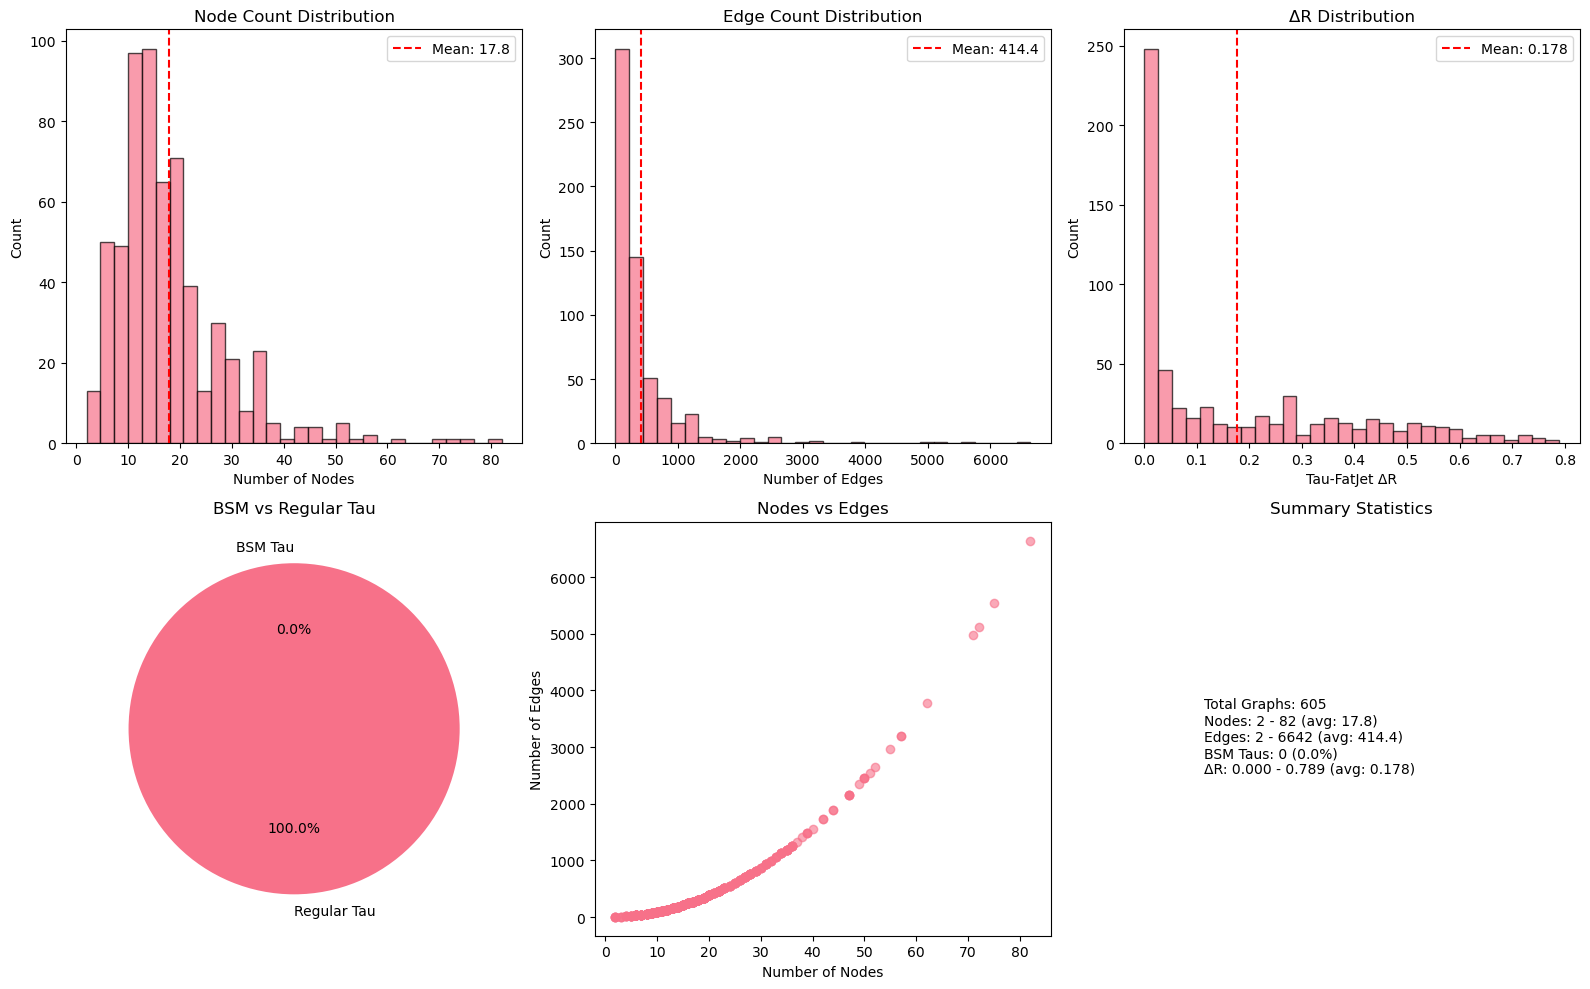

In [5]:
if all_graphs:
    debugger.plot_overview(all_graphs, figsize=(16, 10))
else:
    print("No graphs to plot")

### 3. Individual Graph Analysis

Analyze specific graphs in detail.

In [6]:
if all_graphs:
    @interact(graph_idx=widgets.IntSlider(min=0, max=len(all_graphs)-1, step=1, value=0, 
                                         description='Graph Index:'))
    def show_graph_info(graph_idx):
        graph = all_graphs[graph_idx]
        analysis = debugger.analyze_single_graph(graph, graph_idx)
        
        print(f"=== Graph {graph_idx} Analysis ===")
        print(f"Nodes: {analysis['num_nodes']}")
        print(f"Edges: {analysis['num_edges']}")
        print(f"Node features: {analysis['node_features']}")
        print(f"Global features: {analysis['global_features']}")
        
        if 'is_bsm_tau' in analysis:
            print(f"BSM tau: {analysis['is_bsm_tau']}")
        if 'tau_fatjet_dr' in analysis:
            print(f"Tau-FatJet ΔR: {analysis['tau_fatjet_dr']:.3f}")
        if 'event_idx' in analysis:
            print(f"Event index: {analysis['event_idx']}")
        if 'fatjet_idx' in analysis:
            print(f"FatJet index: {analysis['fatjet_idx']}")
        
        print(f"\nParticle composition:")
        for particle, count in analysis['particle_names'].items():
            print(f"  {particle}: {count}")
        
        print(f"\nNode feature stats (first few features):")
        for feat in ['pt', 'eta', 'phi', 'mass']:
            if feat in analysis['node_feature_stats']:
                stats = analysis['node_feature_stats'][feat]
                print(f"  {feat}: {stats['min']:.2f} - {stats['max']:.2f} (mean: {stats['mean']:.2f})")
else:
    print("No graphs loaded for analysis")

interactive(children=(IntSlider(value=0, description='Graph Index:', max=604), Output()), _dom_classes=('widge…

Detailed analysis of graph 102:


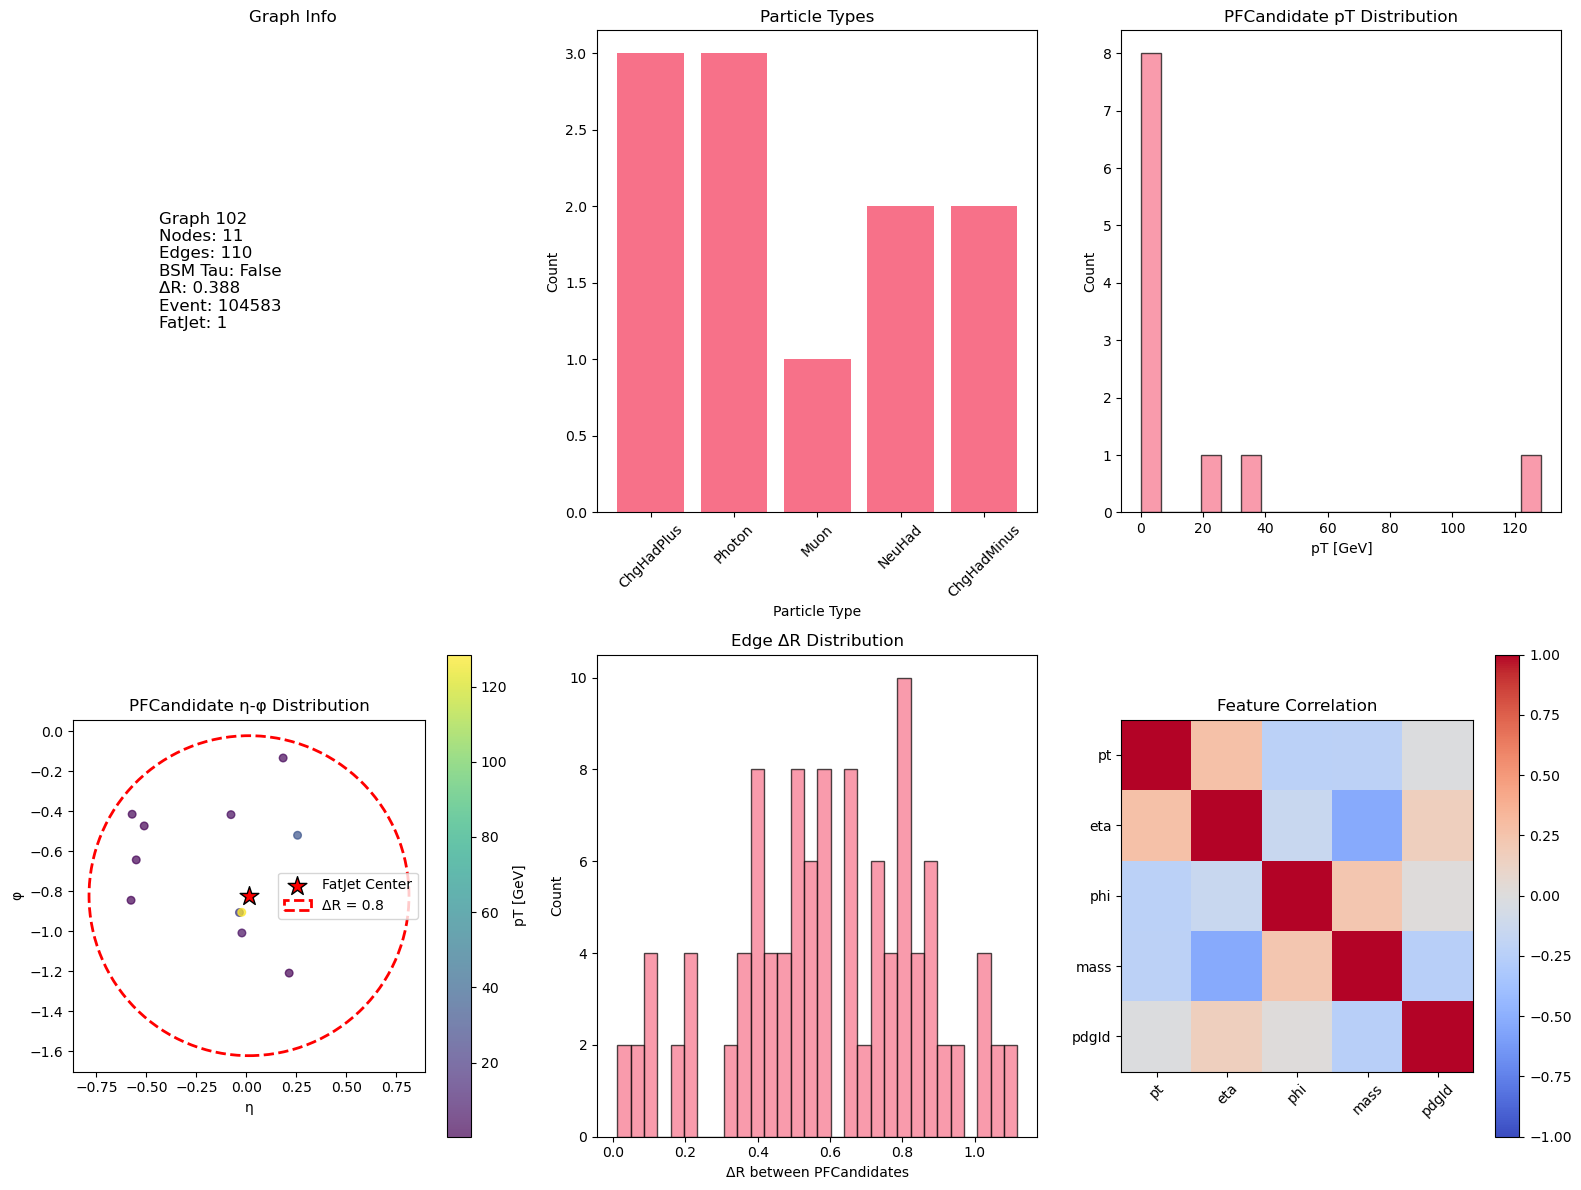

In [7]:
if all_graphs:
    graph_to_analyze = 102  
    
    if graph_to_analyze < len(all_graphs):
        print(f"Detailed analysis of graph {graph_to_analyze}:")
        debugger.plot_single_graph_analysis(all_graphs[graph_to_analyze], 
                                           graph_to_analyze, figsize=(16, 12))
    else:
        print(f"Graph index {graph_to_analyze} out of range (max: {len(all_graphs)-1})")
else:
    print("No graphs loaded for detailed analysis")

### 4. Network Visualization

Visualize graphs as network layouts

In [9]:
if all_graphs:
    small_graphs = [(i, g) for i, g in enumerate(all_graphs) if g.x.shape[0] <= 30]
    
    print(f"Found {len(small_graphs)} graphs with ≤30 nodes suitable for network visualization")
    
    if small_graphs:
        print("Small graph indices and node counts:")
        for i, (graph_idx, graph) in enumerate(small_graphs[:10]):  # Show first 10
            print(f"  Graph {graph_idx}: {graph.x.shape[0]} nodes")
        
        @interact(selection=widgets.Dropdown(
            options=[(f"Graph {idx} ({g.x.shape[0]} nodes)", idx) for idx, g in small_graphs[:20]],
            description='Graph:'),
                 layout=widgets.Dropdown(
                     options=['spring', 'circular', 'random'],
                     value='spring',
                     description='Layout:'))
        def plot_network(selection, layout):
            if selection < len(all_graphs):
                debugger.plot_network_layout(all_graphs[selection], selection, layout, figsize=(14, 7))
    else:
        print("No small graphs found. Try analyzing graphs with fewer nodes.")
else:
    print("No graphs loaded")

Found 538 graphs with ≤30 nodes suitable for network visualization
Small graph indices and node counts:
  Graph 0: 19 nodes
  Graph 2: 14 nodes
  Graph 3: 12 nodes
  Graph 4: 16 nodes
  Graph 5: 16 nodes
  Graph 6: 26 nodes
  Graph 7: 15 nodes
  Graph 8: 3 nodes
  Graph 9: 20 nodes
  Graph 10: 12 nodes


interactive(children=(Dropdown(description='Graph:', options=(('Graph 0 (19 nodes)', 0), ('Graph 2 (14 nodes)'…

### 5. BSM vs Regular Tau Comparison

Compare graphs with BSM taus vs regular taus.

In [16]:
if all_graphs:
    bsm_graphs = [g for g in all_graphs if hasattr(g, 'is_bsm_tau') and g.is_bsm_tau]
    regular_graphs = [g for g in all_graphs if hasattr(g, 'is_bsm_tau') and not g.is_bsm_tau]
    
    print(f"BSM tau graphs: {len(bsm_graphs)}")
    print(f"Regular tau graphs: {len(regular_graphs)}")
    
    if bsm_graphs and regular_graphs:
        bsm_nodes = [g.x.shape[0] for g in bsm_graphs]
        regular_nodes = [g.x.shape[0] for g in regular_graphs]
        
        bsm_drs = [float(g.tau_fatjet_dr) for g in bsm_graphs if hasattr(g, 'tau_fatjet_dr')]
        regular_drs = [float(g.tau_fatjet_dr) for g in regular_graphs if hasattr(g, 'tau_fatjet_dr')]
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        axes[0].hist(regular_nodes, bins=30, alpha=0.7, label='Regular Tau', density=True)
        axes[0].hist(bsm_nodes, bins=30, alpha=0.7, label='BSM Tau', density=True)
        axes[0].set_xlabel('Number of Nodes')
        axes[0].set_ylabel('Density')
        axes[0].set_title('Node Count Distribution')
        axes[0].legend()
        
        if regular_drs and bsm_drs:
            axes[1].hist(regular_drs, bins=30, alpha=0.7, label='Regular Tau', density=True)
            axes[1].hist(bsm_drs, bins=30, alpha=0.7, label='BSM Tau', density=True)
            axes[1].set_xlabel('Tau-FatJet ΔR')
            axes[1].set_ylabel('Density')
            axes[1].set_title('ΔR Distribution')
            axes[1].legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nStatistical Comparison:")
        print(f"Node count - BSM: {np.mean(bsm_nodes):.1f}±{np.std(bsm_nodes):.1f}, Regular: {np.mean(regular_nodes):.1f}±{np.std(regular_nodes):.1f}")
        if regular_drs and bsm_drs:
            print(f"ΔR - BSM: {np.mean(bsm_drs):.3f}±{np.std(bsm_drs):.3f}, Regular: {np.mean(regular_drs):.3f}±{np.std(regular_drs):.3f}")
    else:
        print("Not enough graphs in both categories for comparison")
else:
    print("No graphs loaded")

BSM tau graphs: 0
Regular tau graphs: 605
Not enough graphs in both categories for comparison


In [18]:
if all_graphs:
    high_pt_graphs = []
    for i, graph in enumerate(all_graphs):
        if hasattr(graph, 'u') and graph.u[0] > 200:  # FatJet pT > 200 GeV
            high_pt_graphs.append((i, float(graph.u[0])))
    
    print(f"Found {len(high_pt_graphs)} graphs with FatJet pT > 200 GeV")
    if high_pt_graphs:
        print("Top 5 highest pT:")
        sorted_graphs = sorted(high_pt_graphs, key=lambda x: x[1], reverse=True)[:5]
        for graph_idx, pt in sorted_graphs:
            print(f"  Graph {graph_idx}: {pt:.1f} GeV")
else:
    print("No graphs loaded")

Found 326 graphs with FatJet pT > 200 GeV
Top 5 highest pT:
  Graph 482: 1089.0 GeV
  Graph 175: 591.5 GeV
  Graph 555: 572.0 GeV
  Graph 556: 572.0 GeV
  Graph 230: 537.0 GeV


Overall particle composition:
  ChgHadPlus: 3386 (31.5%)
  ChgHadMinus: 3268 (30.4%)
  Photon: 2441 (22.7%)
  NeuHad: 1414 (13.1%)
  Positron: 77 (0.7%)
  Electron: 76 (0.7%)
  Muon: 48 (0.4%)
  AntiMuon: 48 (0.4%)
  HFHad: 1 (0.0%)


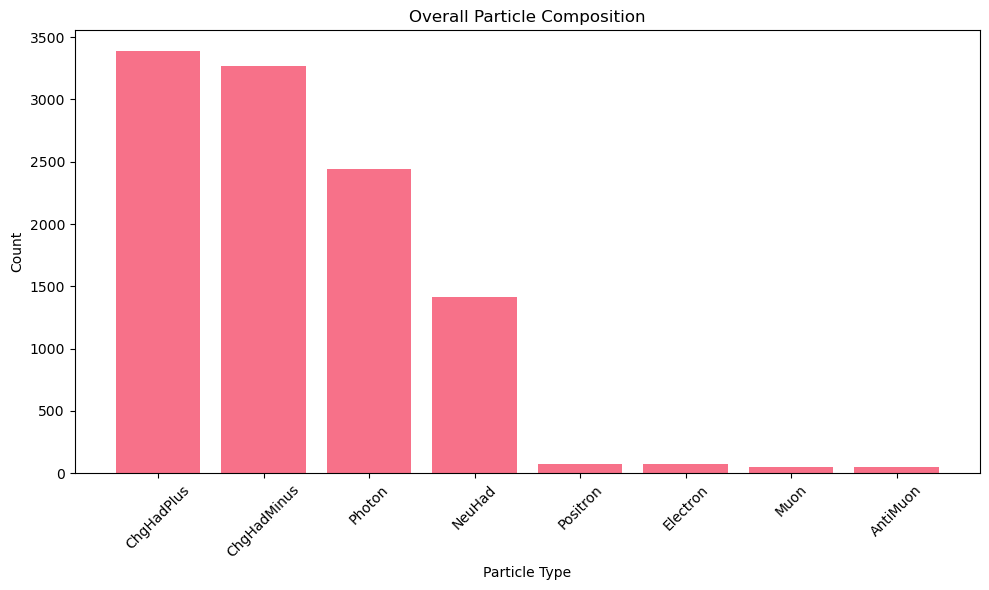

In [10]:
if all_graphs:
    from collections import Counter
    
    all_pdg_ids = []
    for graph in all_graphs:
        pdg_ids = graph.x[:, 4].numpy().astype(int)  # pdgId is 5th feature
        all_pdg_ids.extend(pdg_ids)
    
    pdg_counter = Counter(all_pdg_ids)
    
    print("Overall particle composition:")
    for pdg, count in pdg_counter.most_common(10):
        particle_name = debugger.pdg_names.get(pdg, f"PDG_{pdg}")
        percentage = count / len(all_pdg_ids) * 100
        print(f"  {particle_name}: {count} ({percentage:.1f}%)")
    
    top_particles = pdg_counter.most_common(8)
    names = [debugger.pdg_names.get(pdg, f"PDG_{pdg}") for pdg, _ in top_particles]
    counts = [count for _, count in top_particles]
    
    plt.figure(figsize=(10, 6))
    plt.bar(names, counts)
    plt.xlabel('Particle Type')
    plt.ylabel('Count')
    plt.title('Overall Particle Composition')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No graphs loaded")